In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from keino import Params, k_path, pprint, add_colourbar, vectorize_parallel, colours, build_axes_grid
from ristikko import System, Space, models, Symbol, Site
import joblib

mem = joblib.Memory("cache")

# Triangular lattice

## No sublattice

First we look at some simple cases where there is no sublattice (i.e., a unit cell with a single site).

In [3]:
# Parameters for the system
params = Params(dict(
    N1 = 16,        # number of sites in the a1 direction
    N2 = 16,        # number of sites in the a2 direction
    mu = 0,         # chemical potential
    t = 1,          # hopping energy
    pbc = False,    # open boundary conditions
))


# Create a realspace system, on a triangular lattice
# The second argument could also be a lattice object
# if you want more control, e.g.
# lattice = models.Triangular()
realspace = System(Space.RealSpace, "triangular", params)

# Plot the system
# The system must be in real space to plot
realspace.plot()

### Sanity check - test that the spectra matches the analytic expression

In [5]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)
params = dict(
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
)
params = Params(params)

# Create a path along high symmetry points in momentum space
points = np.array([
    [0, 0],
    [0.5, 0],
    [0.5, 0.5],
    [0, 0.5],
    [0, 0]
]) * 2 * np.pi
Ks = np.array(k_path(101, points))

kspace = System(Space.KSpace, "triangular", params)
Ek = kspace.diagonalise(k=Ks, cache=False)

# Analytic spectra
def hamiltonian(k):
    t, mu, alpha, J, Delta = params.t, params.mu, params.alpha, params.Jz, params.Delta
    a1, a2 = kspace.lattice.lattice_vectors[0], kspace.lattice.lattice_vectors[1]
    rashba_matrix = kspace.lattice.rashba_matrix

    def Hk(k):
        ek = 2*t*np.cos(k @ (-a1 + a2)) + 2*t*np.cos(k @ (a1)) + 2*t*np.cos(k @ (a2)) - mu

        ak = [
            + np.exp(1j * k @ a1) * rashba_matrix[0, 0, 1] * alpha,
            - np.exp(-1j * k @ a1) * rashba_matrix[0, 0, 1] * alpha,
            + np.exp(1j * k @ a2) * rashba_matrix[1, 0, 1] * alpha,
            - np.exp(-1j * k @ a2) * rashba_matrix[1, 0, 1] * alpha,
            + np.exp(1j * k @ (-a1 + a2)) * (-rashba_matrix[0, 0, 1] + rashba_matrix[1, 0, 1]) * alpha,
            - np.exp(-1j * k @ (-a1 + a2)) * (-rashba_matrix[0, 0, 1] + rashba_matrix[1, 0, 1]) * alpha,
        ]
        ak = np.array(ak)
        ak = np.sum(ak, axis=0)
        return np.array([
            [ek + J, ak + params.Jx - 1j * params.Jy],
            [np.conj(ak) + params.Jx + 1j * params.Jy, ek - J]
        ])

    Hk1 = Hk(k)
    Hk2 = Hk(-k)
    D = np.array([[0, Delta], [-Delta, 0]])
    H_BdG = np.block([
        [Hk1, D],
        [-D, -Hk2.T]
    ])
    return H_BdG
ref = np.array([np.linalg.eigvalsh(hamiltonian(k)) for k in Ks])




# Compare the spectra
ref_flat = np.sort(ref.flatten())
Ek_flat = np.sort(Ek.flatten())
test = abs(ref_flat - Ek_flat).max()

assert test < 1e-13

In [6]:
fig, axis = plt.subplots()
axis.plot(Ek, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy E/t")

ticks = np.linspace(0, 101, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)

### Sanity check - test that the momentum-space spectra matches real space

In [7]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)
params = dict(
        N1 = 16,
        N2 = 16,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
        pbc = True,
)
params = Params(params)

# Create a real space system
realspace = System(Space.RealSpace, "triangular", params)

# Compare to momentum space
# Under the bonnet this creates an equivalent system in momentum space,
# discretises the Brillouin zone appropriately,
# and compares the eigenenergies
assert realspace == Space.KSpace

### Sanity check - test that the momentum-space spectra matches a ribbon

In [8]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)

params_ribbon = dict(
        N1 = 6,              # use 6 discretisation points in momentum space
        N2 = 5,
        L = 5,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
        pbc = True,
        direction = "a1",    # Fourier-transform along the a1 direction
)
params_ribbon = Params(params_ribbon)
params_kspace = dict(
        N1 = 6,
        N2 = 5,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
)
params_kspace = Params(params_kspace)

syst = System(Space.Ribbon, "triangular", params_ribbon)
kspace = System(Space.KSpace, "triangular", params_kspace)

assert syst == kspace

### Ribbon band structure

In [9]:
params = Params(dict(
    L = 11,
    mu = 0,
    t = 1,
    direction = "a2",    # Fourier transform along the a2 direction
    pbc = False,
))

# Create system
syst = System(Space.Ribbon, "triangular", params)

# Discretise momenta
nk = 101
Ks = np.linspace(-np.pi, np.pi, nk)
Ek = np.array(syst.diagonalise(k=Ks, dense=True, cache=False))

In [10]:
fig, axis = plt.subplots(figsize=(3, 2))
axis.plot(Ek/params.t, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy [t]")
ticks = np.linspace(0, nk, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)
plt.show()

### Density of states and local density of states

In [11]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)
params = dict(
        N1 = 16,
        N2 = 16,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
        pbc = True,
)
params = Params(params)

# Create a real space system
realspace = System(Space.RealSpace, "triangular", params)

# Calculate the LDOS
omega = np.linspace(-0.1, 0.1, 1001)
ldos = realspace.calc_ldos(omega)   # returns shape particle/hole, N1, N2, N1_sub, N2_sub, n_orbitals, len(omega)

In [12]:
dos = ldos[0].sum(axis=(0, 1, 2, 3, 4))

fig, axis = plt.subplots()

axis.plot(omega, dos, color="black")
axis.set_xlabel(r"energy $\omega$")
axis.set_ylabel("DOS [a.u]")

Text(0, 0.5, 'DOS [a.u]')

In [13]:
@interact(idx=(0, len(omega)-1))
def play(idx=0):
    _ldos = ldos[0, :, :, 0, 0, :, idx].sum(axis=-1)
    
    fig, axis = plt.subplots(figsize=(5, 5))
    im = axis.contourf(_ldos)

    add_colourbar(fig, axis, im)

    axis.set_xlabel("x")
    axis.set_ylabel("y")
    axis.set_xticks([])
    axis.set_yticks([])

interactive(children=(IntSlider(value=0, description='idx', max=1000), Output()), _dom_classes=('widget-intera…

## Shiba chain on substrate

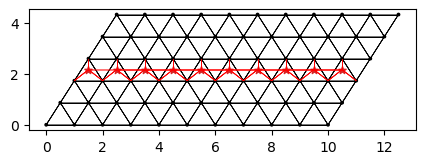

In [2]:
params = dict(
    N1 = 11,
    N2 = 6,
    t = 1,
    mu = -2,
    alpha = 0.5,
    Delta = 1,
    impurities = dict(
        t = 1,
        Gamma = 1,
        mu = 0.5,
        J = 2.5,
        L = 10,
    ),
    pbc = False,
)
params = Params(params)

sys = System(Space.RealSpace, "triangular", params)
sys.set_geometry("chain")
sys.plot()

### Sanity check - real space matches momentum space

In [6]:
params = dict(
    N1 = 11,
    N2 = 6,
    t = 1,
    mu = 5.45,
    alpha = 0.5,
    Delta = 1,
    impurities = dict(
        t = 1,
        Gamma = 1,
        mu = 0.5,
        J = 2.5,
        L = 11,
        pbc = True,
    ),
    pbc = True,
)
params = Params(params)

realspace = System(Space.RealSpace, "triangular", params)
realspace.set_geometry("chain")

params.impurities.L = 1
params.N2 = 1
lattice = models.Triangular()
sublattice = models.Triangular(N1=1, N2=6)
lattice.add_sublattice(sublattice)
kspace = System(Space.KSpace, lattice, params)
kspace.set_geometry("chain")

realspace == kspace

np.True_

### LDOS

In [35]:
params = dict(
    N1 = 51,
    N2 = 6,
    t = 1,
    mu = 5.45,
    alpha = 0.5,
    Delta = 1,
    impurities = dict(
        # t = 1,
        Gamma = 1,
        mu = 0.5,
        J = 0.5,
        L = 11,
        spacing = 1,
    ),
    pbc = False,
)
params = Params(params)

realspace = System(Space.RealSpace, "triangular", params)
realspace.set_geometry("chain")

omega = np.linspace(-2, 2, 1001)
ldos = realspace.calc_ldos(omega, delta=0.01)

# realspace.plot(axis_scale=20)

Text(0, 0.5, 'DOS [a.u]')

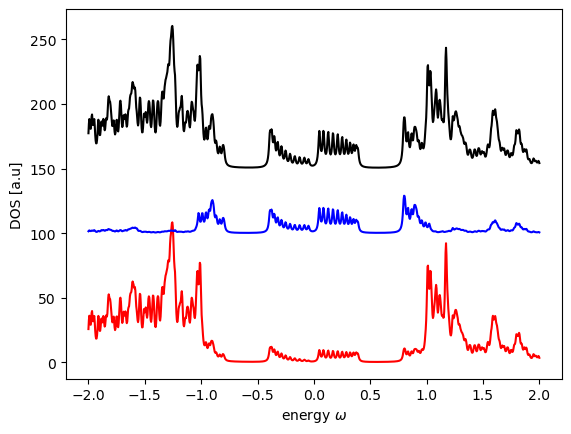

In [36]:
dos = (
    ldos[0][0].sum(axis=(0, 1, 2, 3, 4)),
    ldos[1][0].sum(axis=(0, 1)),
)
dos_tot = np.sum(dos, axis=0)

fig, axis = plt.subplots()

axis.plot(omega, dos[0], color="red")
axis.plot(omega, dos[1]+100, color="blue")
axis.plot(omega, dos_tot+150, color="black")
axis.set_xlabel(r"energy $\omega$")
axis.set_ylabel("DOS [a.u]")

In [37]:
@interact(idx=(0, len(omega)-1))
def play(idx=len(omega)//2):
    _ldos = ldos[0][0, :, :, 0, 0, :, idx].sum(axis=-1)

    fig, axis = plt.subplots(figsize=(5, 5))
    axis.plot(_ldos, ".-")

    axis.set_xlabel("x")
    axis.set_ylabel("y")

interactive(children=(IntSlider(value=500, description='idx', max=1000), Output()), _dom_classes=('widget-inte…

### Topology

In [2]:
def build_system(mu, J):
    params = dict(
        t = 1,
        mu = 5.45,
        alpha = 0.25,
        Delta = 0.7,
        impurities = dict(
            # t = 1,
            Gamma = 0.35,
            mu = mu,
            J = J,
            L = 1,
        ),
        pbc = True,
    )
    params = Params(params)
    
    lattice = models.Triangular()
    sublattice = models.Triangular(N1=2, N2=6)
    lattice.add_sublattice(sublattice)
    sys = System(Space.KSpace, lattice, params)
    sys.set_geometry("chain")
    return sys
    
@vectorize_parallel
def calc(mu, J):
    sys = build_system(mu, J)
    M = sys.calc_majorana()
    return M

In [5]:
Mus = np.linspace(0, 0.3, 31)
Js = np.linspace(0, 0.3, 33)

M = calc(Mus[None, :], Js[:, None], mem=mem, progress=True)

  0%|          | 0/1023 [00:00<?, ?it/s]

Text(0, 0.5, 'exchange energy $J$')

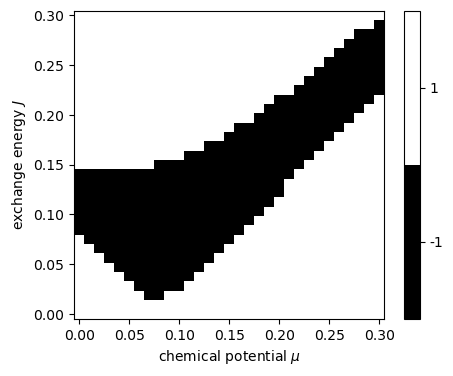

In [8]:
fig, axis = plt.subplots(figsize=(4, 4))
cmap = colours.BlackWhite()
im = axis.pcolormesh(Mus, Js, M, cmap=cmap)
cbar, cax = add_colourbar(fig, axis, im)
cax.set_yticks([-0.5, 0.5], [-1, 1])
axis.set_xlabel(r"chemical potential $\mu$")
axis.set_ylabel("exchange energy $J$")